In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        k = np.sqrt(1/hidden_size)

        self.hidden_size = hidden_size
        self.bias = torch.zeros(hidden_size, requires_grad=True)
        self.Wx = torch.FloatTensor(input_size, hidden_size).uniform_(-k, k)
        self.Wy = torch.FloatTensor(hidden_size, hidden_size).uniform_(-k, k)
        self.Wx.requires_grad = True
        self.Wy.requires_grad = True
        self.tanh = nn.Tanh()

    def forward(self, input_data, hidden):
        W = torch.cat([self.Wx, self.Wy], dim=0)
        X = torch.cat([input_data, hidden], dim=1)
        hidden = self.tanh(torch.mm(X, W) + self.bias)
        return hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size = 5
batch_size = 3

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([3, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
new_hidden:  [[ 0.48852932 -0.02923582  0.4359608   0.11287742 -0.63422376]
 [ 0.4288813  -0.02052058  0.5877922   0.25754666 -0.61170495]
 [ 0.19471844 -0.04657943  0.67073685  0.43946433 -0.3579096 ]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[ 0.70984244  0.44014943  0.41372883  0.1740331  -0.79276884]
 [ 0.6569835   0.42927143  0.58633     0.30282962 -0.75078   ]
 [ 0.36507118  0.21390495  0.68765223  0.45198283 -0.41416025]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 4 root root 4.0K May 20 09:18 MNIST


Populating the interactive namespace from numpy and matplotlib


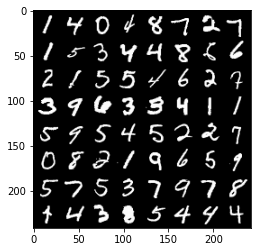

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        # просто сделал более наглядно
        self.FC = nn.Sequential(
            nn.Linear(self.n_neurons, self.n_outputs),
            nn.LogSoftmax(dim=1)
        )
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-4.1371, -4.1753, -4.1824, -4.1319, -4.1378, -4.1357, -4.1019, -4.1332,
         -4.1763, -4.1514],
        [-4.1644, -4.1609, -4.1536, -4.1635, -4.1699, -4.1537, -4.1650, -4.1660,
         -4.1557, -4.1531],
        [-4.1603, -4.1623, -4.1601, -4.1641, -4.1582, -4.1601, -4.1551, -4.1567,
         -4.1631, -4.1467],
        [-4.1486, -4.1707, -4.1663, -4.1523, -4.1482, -4.1601, -4.1613, -4.1574,
         -4.1518, -4.1405],
        [-4.1549, -4.1822, -4.1231, -4.1487, -4.1735, -4.1704, -4.1773, -4.1361,
         -4.1647, -4.1910],
        [-4.1620, -4.1585, -4.1630, -4.1616, -4.1592, -4.1658, -4.1600, -4.1593,
         -4.1589, -4.1599],
        [-4.1772, -4.1763, -4.1336, -4.1387, -4.1314, -4.2012, -4.1706, -4.1403,
         -4.1837, -4.2029],
        [-4.1610, -4.1580, -4.1640, -4.1651, -4.1642, -4.1559, -4.1538, -4.1573,
         -4.1645, -4.1475],
        [-4.1452, -4.1638, -4.1504, -4.1523, -4.1634, -4.1571, -4.1545, -4.1513,
         -4.1685, -4.1657],
        [-4.1568, -

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 2.5533 | Train Accuracy: 81.26
Epoch:  1 | Loss: 2.2282 | Train Accuracy: 91.75
Epoch:  2 | Loss: 2.1548 | Train Accuracy: 93.81
Epoch:  3 | Loss: 2.1247 | Train Accuracy: 94.62
Epoch:  4 | Loss: 2.0926 | Train Accuracy: 95.49
Epoch:  5 | Loss: 2.0777 | Train Accuracy: 95.79
Epoch:  6 | Loss: 2.0636 | Train Accuracy: 96.21
Epoch:  7 | Loss: 2.0547 | Train Accuracy: 96.51
Epoch:  8 | Loss: 2.0498 | Train Accuracy: 96.69
Epoch:  9 | Loss: 2.0402 | Train Accuracy: 96.90


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.81


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [ ]:
# это уберет боль работы с текстами
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchtext==0.9
!python -m spacy download en

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.2 MB/s eta 0:15:30tcmalloc: large alloc 1147494400 bytes == 0x398d4000 @  0x7f9f3b657615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:51tcmalloc: large alloc 1434370048 bytes == 0x7df2a000 @  0x7f9f3b657615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████▋          | 1336.2 MB 1.3 MB/s eta 0:08:23tcmalloc: large alloc 1792966656 bytes =

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 60.8MB/s]


In [ ]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [120]:
print(vars(train_data.examples[0]))

{'text': ['I', 'must', 'admit', 'I', 'do', 'not', 'hold', 'much', 'of', 'New', 'Age', 'mumbo', 'jumbo', '.', 'When', 'people', '"', 'exchange', 'energy', '"', 'I', 'always', 'wonder', 'how', 'much', 'kJ', 'is', 'actually', 'exchanged', 'and', 'how', 'it', 'may', 'contribute', 'to', 'solving', 'the', 'global', 'warming', 'problem', '.', 'When', 'energy', '"', 'is', 'enforced', '"', 'I', 'always', 'wonder', 'how', 'they', 'managed', 'to', 'violate', 'the', 'laws', 'of', 'entropy', 'and', 'still', 'are', 'without', 'Nobel', 'prizes', '.', 'When', 'people', 'feel', 'how', 'well', 'instinct', 'enables', 'them', 'to', 'flawlessly', 'navigate', 'through', 'the', 'complexities', 'of', 'life', 'I', 'wonder', 'how', 'they', 'fail', 'to', 'do', 'a', 'simple', 'thing', 'like', 'finding', 'the', 'train', 'station.<br', '/><br', '/>But', 'then', 'again', ',', 'this', 'is', 'not', 'the', 'first', 'movie', 'with', 'plot', 'holes', 'and', 'most', 'of', 'them', 'I', 'find', 'perfectly', 'acceptable', 'a

In [121]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [122]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [123]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [124]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 6191, 'pos': 6059}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [125]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 142130), (',', 134839), ('.', 115766), ('a', 76456), ('and', 76367), ('of', 70649), ('to', 65698), ('is', 53138), ('in', 43133), ('I', 38021), ('it', 37430), ('that', 34534), ('"', 31117), ("'s", 30438), ('this', 29530), ('-', 26243), ('/><br', 25140), ('was', 24399), ('as', 21332), ('with', 21059)]


* stoi (string to int)
* itos (int to string)

In [126]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']


In [127]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [128]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [141]:
from tqdm.notebook import tqdm
from torch import nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
def accuracy(predict, target, threshold=0.5, bc=1):
    return ((predict > threshold).long() == target).sum().item()/bc

In [151]:
EMBEDDING = 400
N_NEURONS = 256
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT_RNN = .5
DROPOUT_FC = .5
# 
EPOCHS = 10
LR = 1e-3

In [152]:
class GRU(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, 
                          num_layers=N_LAYERS, bidirectional=BIDIRECTIONAL,
                          dropout=DROPOUT_RNN)
        fc_in = (2 if BIDIRECTIONAL else 1)*hidden_dim*2
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=DROPOUT_FC),
            nn.BatchNorm1d(fc_in),
            nn.Linear(fc_in, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        out = torch.cat([output[-1], output[0]], 1)
        out = self.fc(out)
        
        return out.squeeze()

In [153]:
model = GRU(len(TEXT.vocab), EMBEDDING, N_NEURONS).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [154]:
history = {
    "train_loss":[], "val_loss":[],
    "train_accuracy":[], "val_accuracy":[],
    "grads":[]
}
for epoch in range(1, EPOCHS+1):
    # Train
    train_avg_loss = 0
    train_avg_acc = 0
    train_loader = tqdm(
        enumerate(train_iterator), leave=False, total=len(train_iterator))
    for i, batch in train_loader:
        text = batch.text.to(device)
        label = batch.label.to(device)
        optimizer.zero_grad()

        predict = model(text)
        loss = criterion(predict, label)
        loss.backward()

        optimizer.step()

        train_avg_loss += loss.item()
        train_avg_acc += accuracy(predict, label, bc=BATCH_SIZE)

        train_loader.set_postfix(
            avg_loss=train_avg_loss/(i+1), 
            avg_accuracy=train_avg_acc/(i+1)
            )
        
    train_avg_loss /= (i+1)
    train_avg_acc /= (i+1)
    
    # Validation
    val_avg_loss = 0
    val_avg_acc = 0
    val_loader = tqdm(
        enumerate(valid_iterator), leave=False, total=len(valid_iterator))
    model.eval()
    with torch.no_grad():
      for i, batch in val_loader:
          text = batch.text.to(device)
          label = batch.label.to(device)

          predict = model(text)
          loss = criterion(predict, label)

          val_avg_loss += loss.item()
          val_avg_acc += accuracy(predict, label, bc=BATCH_SIZE)

          val_loader.set_postfix(
            avg_loss=val_avg_loss/(i+1), 
            avg_accuracy=val_avg_acc/(i+1)
            )
    model.train()

    val_avg_loss /= (i+1)
    val_avg_acc /= (i+1)

    history["train_loss"].append(train_avg_loss)
    history["val_loss"].append(val_avg_loss)
    history["train_accuracy"].append(train_avg_acc)
    history["val_accuracy"].append(val_avg_acc)

    print("Epoch %d | train_loss: %.4f | val_accuracy: %.4f" % (epoch, train_avg_loss, val_avg_acc))

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 1 | train_loss: 0.6939 | val_accuracy: 0.6158


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 2 | train_loss: 0.4734 | val_accuracy: 0.7814


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 3 | train_loss: 0.2313 | val_accuracy: 0.8607


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 4 | train_loss: 0.1087 | val_accuracy: 0.8328


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 5 | train_loss: 0.0483 | val_accuracy: 0.8486


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 6 | train_loss: 0.0214 | val_accuracy: 0.8607


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 7 | train_loss: 0.0124 | val_accuracy: 0.8603


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 8 | train_loss: 0.0291 | val_accuracy: 0.8456


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 9 | train_loss: 0.0213 | val_accuracy: 0.8622


  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Epoch 10 | train_loss: 0.0107 | val_accuracy: 0.8656


In [158]:
def plot_duo(train, test, ylabel=None, title=None, figsize=(10, 10)):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(x=range(1, len(train)+1), y=train, label="train", ax=ax)
    sns.lineplot(x=range(1, len(test)+1), y=test, label="test", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("epoch")
    ax.set_ylabel(ylabel)
    plt.show()

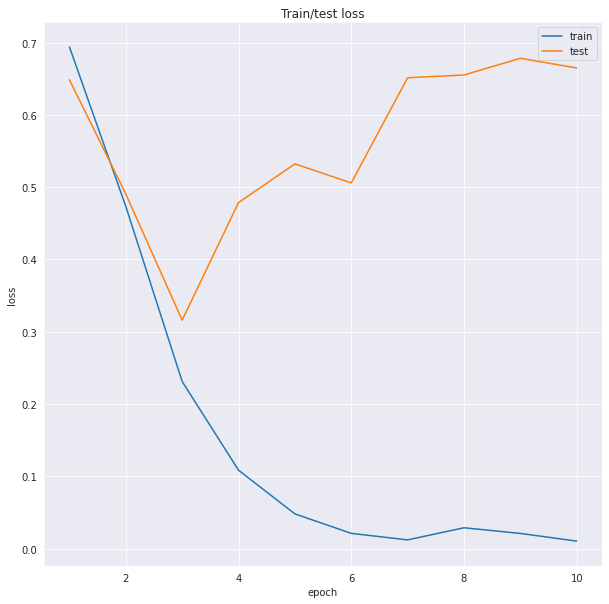

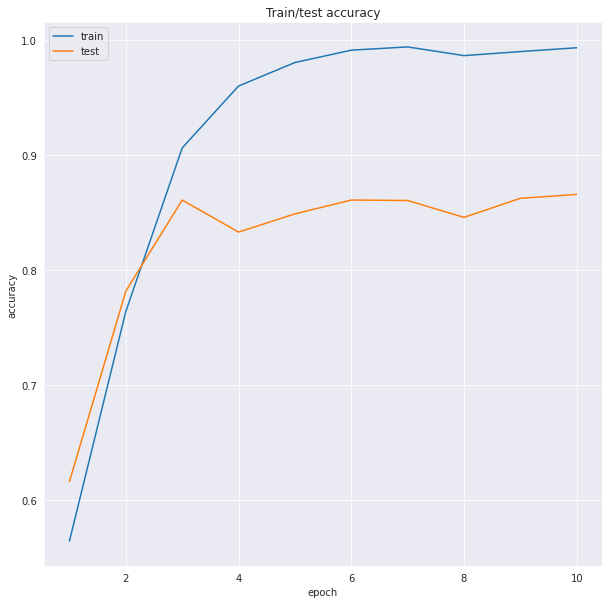

In [159]:
plot_duo(history["train_loss"], history["val_loss"], title="Train/test loss", ylabel="loss")
plot_duo(history["train_accuracy"], history["val_accuracy"], title="Train/test accuracy", ylabel="accuracy")

In [157]:
print('Test')
test_avg_acc = 0
test_loader = tqdm(
    enumerate(test_iterator), leave=False, total=len(test_iterator))
model.eval()
with torch.no_grad():
  for i, batch in test_loader:
      text = batch.text.to(device)
      label = batch.label.to(device)

      predict = model(text)
      acc = accuracy(predict, label, bc=BATCH_SIZE)

      test_avg_acc += acc

      test_loader.set_postfix(
            avg_accuracy=test_avg_acc/(i+1)
            )
model.train()

test_avg_acc /= i+1
clear_output()
print("Test Accuracy: %.4f" % test_avg_acc)

Test Accuracy: 0.8684
